## Spatial Bootstrap and Uncertainty

In [89]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.
import random

In [90]:
df = pd.read_csv('df_nscored.csv')
df_sand = pd.read_csv('dfsand_nscored.csv')
df_shale = pd.read_csv('dfshale_nscored.csv')

In [91]:
ind_vario = np.load('indicatorvariogram.npy').item()
sandpor_vario = np.load('sandporosityvariogram.npy').item()
shalepor_vario = np.load('shaleporosityvariogram.npy').item()
sandperm_vario = np.load('sandpermeabilityvariogram.npy').item()
shaleperm_vario = np.load('shalepermeabilityvariogram.npy').item()

In [92]:
por_trend = np.load('porositytrend.npy')
perm_trend = np.load('permeabilitytrend.npy')

In [93]:
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=16)

In [94]:
# functions for spatial bootstrap
from numba import jit # for numerical speed up
import scipy
@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.14159265
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    var_range = 100.0
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff
    

### Uncertainty in Facies Proportions

In [95]:
# calculating n_effective
n_eff = n_effective(df,'X','Y',seed=1,nreal=1000,vario=ind_vario)
print('Number of effective data = ' + str(round(n_eff,2)) + ' / ' + str(len(df)) + '.')

Number of effective data = 20.02 / 217.


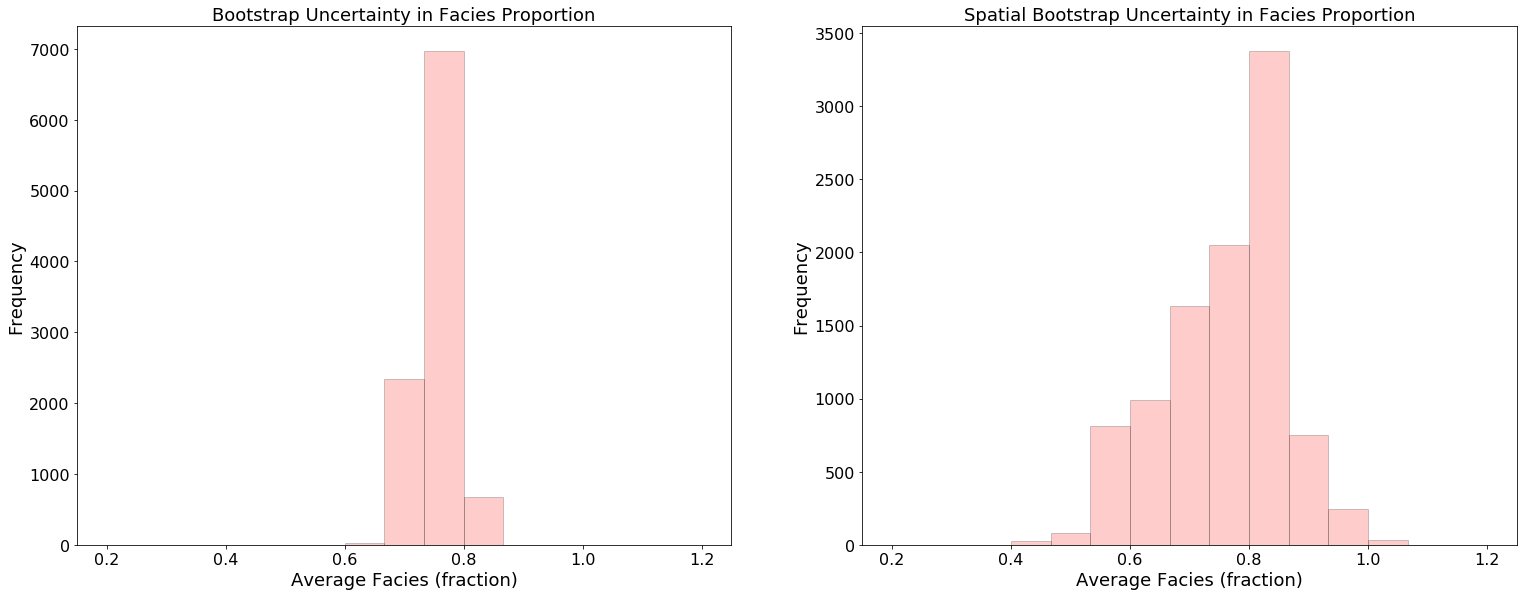

In [96]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
facies_mean = np.zeros(L); spatial_mean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df['Facies'].values, weights=None, cum_weights=None, k=len(df))
    spatial_samples = random.choices(df['Facies'].values, weights=None, cum_weights=None, k=int(n_eff))

    facies_mean[l] = np.average(samples)
    spatial_mean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(facies_mean,0.2,1.2,False,False,15,None,
              'Average Facies (fraction)','Bootstrap Uncertainty in Facies Proportion')

plt.subplot(122)
GSLIB.hist_st(spatial_mean,0.2,1.2,False,False,15,None,
              'Average Facies (fraction)','Spatial Bootstrap Uncertainty in Facies Proportion')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

### Uncertainty in porosity mean (by-facies)

In [97]:
# calculating n_effective
sandpor_n_eff = n_effective(df_sand,'X','Y',seed=1,nreal=1000,vario=sandpor_vario)
print('Number of effective data (Sandstone Porosity) = ' + str(round(sandpor_n_eff,2)) + ' / ' + str(len(df_sand)) + '.')

Number of effective data (Sandstone Porosity) = 91.61 / 164.


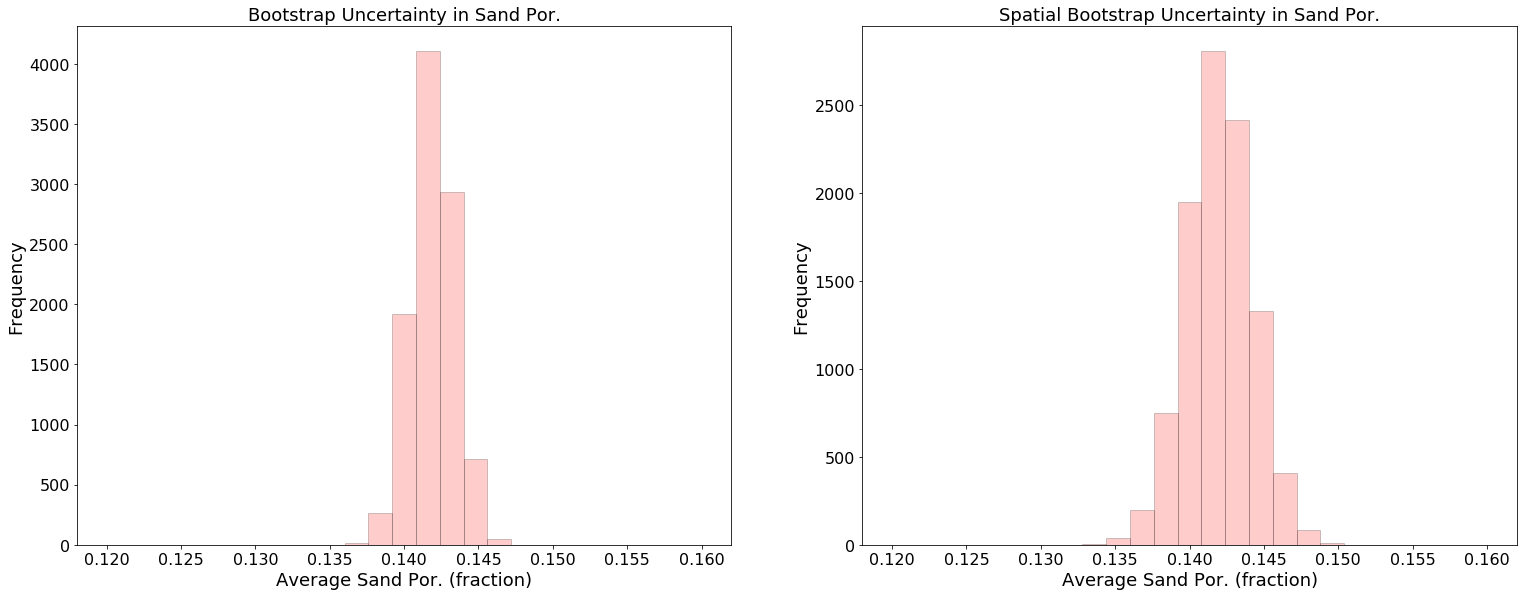

In [98]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
sandpor_mean = np.zeros(L); spatial_sandpormean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df_sand['Porosity'].values,
                             weights=None, cum_weights=None, k=len(df))
    
    spatial_samples = random.choices(df_sand['Porosity'].values,
                                     weights=None, cum_weights=None, k=int(sandpor_n_eff))

    sandpor_mean[l] = np.average(samples)
    spatial_sandpormean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(sandpor_mean,0.12,0.16,False,False,25,None,
              'Average Sand Por. (fraction)','Bootstrap Uncertainty in Sand Por.')

plt.subplot(122)
GSLIB.hist_st(spatial_sandpormean,0.12,0.16,False,False,25,None,
              'Average Sand Por. (fraction)','Spatial Bootstrap Uncertainty in Sand Por.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [99]:
# calculating n_effective
shalepor_n_eff = n_effective(df_shale,'X','Y',seed=1,nreal=1000,vario=shalepor_vario)
print('Number of effective data (Shale Porosity) = ' + str(round(shalepor_n_eff,2)) + ' / ' + str(len(df_shale)) + '.')

Number of effective data (Shale Porosity) = 42.14 / 53.


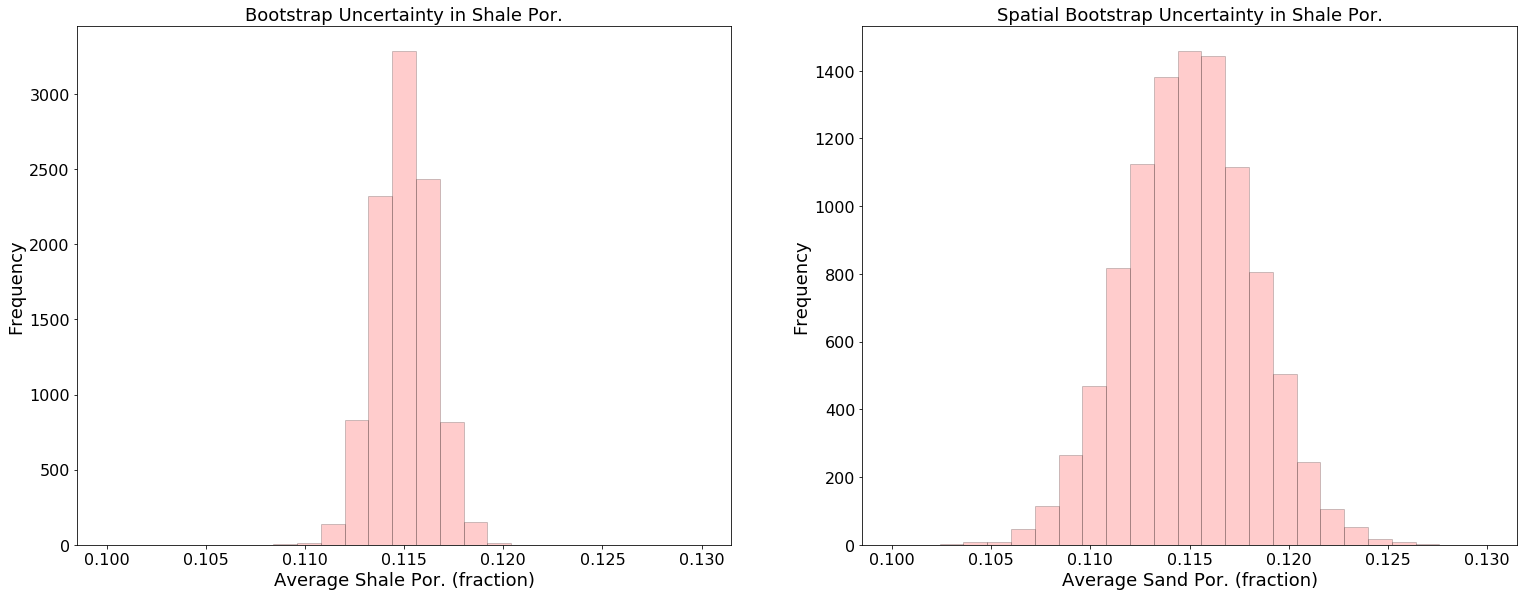

In [100]:
# comparing bootstrap and spatial boostrap
L = 10000                                      # set the number of realizations for uncertainty calculation
shalepor_mean = np.zeros(L); spatial_shalepormean = np.zeros(L) # declare arrays to hold the realizations of the statistics
P10 = np.zeros(L)                          
P50 = np.zeros(L); P90 = np.zeros(L)                         
for l in range(0, L):                          # loop over realizations
    samples = random.choices(df_shale['Porosity'].values,
                             weights=None, cum_weights=None, k=len(df))
    
    spatial_samples = random.choices(df_shale['Porosity'].values,
                                     weights=None, cum_weights=None, k=int(shalepor_n_eff))

    shalepor_mean[l] = np.average(samples)
    spatial_shalepormean[l] = np.average(spatial_samples)
    
plt.subplot(121)
GSLIB.hist_st(shalepor_mean,0.10,0.13,False,False,25,None,
              'Average Shale Por. (fraction)','Bootstrap Uncertainty in Shale Por.')

plt.subplot(122)
GSLIB.hist_st(spatial_shalepormean,0.10,0.13,False,False,25,None,
              'Average Sand Por. (fraction)','Spatial Bootstrap Uncertainty in Shale Por.')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

## Post-Sim Uncertainty Quant

In [101]:
# functions
def local_expectation(realizations):                      # calculate the local expectation / average realization
    cond_exp = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            cond_exp[iy,ix] = np.average(a = realizations[:,iy,ix])  
    return cond_exp

def local_standard_deviation(realizations):               # calculate the local standard deviation of realizations
    local_stdev = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            local_stdev[iy,ix] = np.std(a = realizations[:,iy,ix])  
    return local_stdev
 
def local_percentile(realizations,p_value):               # calculate the local percentile of realizations
    percentile = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            percentile[iy,ix] = np.percentile(a = realizations[:,iy,ix], q = p_value)  
    return percentile

def local_probability_exceedance(realizations,threshold): # calculate the local probability of exceeding a threshold 
    prob_exceed = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            prob_exceed[iy,ix] = np.sum(realizations[:,iy,ix] >= threshold)/realizations[:,0,0].size 
    return prob_exceed

### Use the n_effective points to sample from original data and run simulations on those

In [102]:
# Sequential Indicator Simulation Settings
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; nodmax = 10; radius = 100; skmean = 0
tmin = -999; tmax = 999
dummy_trend = np.zeros((10,10))            # the current version requires trend input - if wrong size it is ignored 

ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories (use consistent order)
gcdf = [0.24,0.76]                         # the global proportions of the categories - from update 4
varios = []                                # the variogram list

varios.append(ind_vario)
varios.append(ind_vario)

In [103]:
# 20 simulations of facies, sand porosity, and shale porosity using random spatial bootstrap
num_sim = 100
sim_ik = np.zeros([num_sim,nx,ny]) # preallocate array to hold SIS results
sandporsim = np.zeros([num_sim,nx,ny]) # preallocate array for sandstone porosity SGS results
shaleporsim = np.zeros([num_sim,nx,ny]) # preallocate array for shale porosity SGS results
cookie_por = np.zeros([num_sim,nx,ny]) # pre-allocate porosity cookie-cutter array

for i in range(0,num_sim):
    # spatial bootstrap facies
    df = df.sample(int(n_eff))         
    df = df.reset_index()       
    # spatial bootstrap sand porosity
    df_sand = df_sand.sample(int(sandpor_n_eff))
    df_sand = df_sand.reset_index()
    # spatial bootstrap shale porosity
    df_shale = df_shale.sample(int(shalepor_n_eff))
    df_shale = df_shale.reset_index()
    
    # SIS Facies
    sim_ik[i,:,:] = geostats.sisim(df,'X','Y','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,
                                   gcdf=gcdf,trend=dummy_trend,tmin=tmin,tmax=tmax,zmin=0.0,
                                   zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,
                                   nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed = i,
                                   ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,
                                   noct=-1,radius=radius,ktype=0,vario=varios)
    # SGS Sandstone Porosity Residuals
    sandporsim[i,:,:] = geostats.sgsim(df_sand,'X','Y','Por_Res',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,
                                       itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,zmin=0.0,
                                       zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,nx=nx,
                                       xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=i,ndmin=ndmin,
                                       ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,
                                       radius1=1,sang1=0,mxctx=10,mxcty=10,ktype=0,colocorr=0.0,
                                       sec_map=0,vario=sandpor_vario)
    # SGS Shale Porosity Residuals
    shaleporsim[i,:,:] = geostats.sgsim(df_shale,'X','Y','Por_Res',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,
                                        itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,zmin=0.0,
                                        zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,nx=nx,
                                        xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=i,
                                        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
                                        radius=radius,radius1=1,sang1=0,mxctx=10,mxcty=10,ktype=0,
                                        colocorr=0.0,sec_map=0,vario=shalepor_vario)
    # cookie-cutter porosity results together
    for k in range(0,nx):
        for j in range(0,ny):
            if sim_ik[i,k,j] == 0:
                cookie_por[i,k,j] = shaleporsim[i,k,j]
            else:
                cookie_por[i,k,j] = sandporsim[i,k,j]
    cookie_por[i,:,:] = cookie_por[i,:,:] + por_trend
    # reload DataFrames
    df = pd.read_csv('df_nscored.csv')
    df_sand = pd.read_csv('dfsand_nscored.csv')
    df_shale = pd.read_csv('dfshale_nscored.csv')

# Save the simulations
np.save('uncertaintyporosity100.npy',cookie_por)

Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average              = 0.0046
                 Weighted Variance             = 0.0004
                 Weighted Transformed Average  = 0.0
                 Weighted Transformed Variance = 0.9861
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   cu

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.013 (close to 0.0?)
                                   variance = 0.9394 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 4
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average    

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0337 (close to 0.0?)
                                   variance = 0.8982 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 8
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0365 (close to 0.0?)
                                   variance = 0.8884 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 12
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.002 (close to 0.0?)
                                   variance = 0.9101 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 16
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0006 (close to 0.0?)
                                   variance = 0.9631 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 20
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.034 (close to 0.0?)
                                   variance = 0.9245 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 24
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average    

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0122 (close to 0.0?)
                                   variance = 0.9284 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 28
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0117 (close to 0.0?)
                                   variance = 0.936 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 32
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0183 (close to 0.0?)
                                   variance = 0.8943 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 36
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0317 (close to 0.0?)
                                   variance = 0.9309 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 40
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0466 (close to 0.0?)
                                   variance = 0.8995 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 44
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.025 (close to 0.0?)
                                   variance = 0.9517 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 48
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0047 (close to 0.0?)
                                   variance = 0.8611 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 52
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0603 (close to 0.0?)
                                   variance = 0.9506 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 56
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0278 (close to 0.0?)
                                   variance = 0.9089 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 60
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0841 (close to 0.0?)
                                   variance = 0.9347 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 64
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0288 (close to 0.0?)
                                   variance = 0.9123 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 68
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0416 (close to 0.0?)
                                   variance = 0.9138 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 72
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0234 (close to 0.0?)
                                   variance = 0.9825 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 76
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0487 (close to 0.0?)
                                   variance = 0.876 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 80
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average    

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0291 (close to 0.0?)
                                   variance = 0.9246 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 84
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0004 (close to 0.0?)
                                   variance = 0.9166 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 88
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average   

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0233 (close to 0.0?)
                                   variance = 0.8706 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 92
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0043 (close to 0.0?)
                                   variance = 0.9365 (close to gammabar(V,V)? approx. 1.0)
Data for IK3D: Variable column Facies
  Number   = 20
Setting up rotation matrices for variogram and search
Working on a single realization, seed 96
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000

 Data for SGSIM: Number of acceptable data     = 91
                 Number trimmed                = 0
                 Weighted Average  

   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.0331 (close to 0.0?)
                                   variance = 0.9485 (close to gammabar(V,V)? approx. 1.0)


In [9]:
# Save the 20 simulations
np.save('uncertaintyporosity.npy',cookie_por)

## Post-sim uncertainty summary

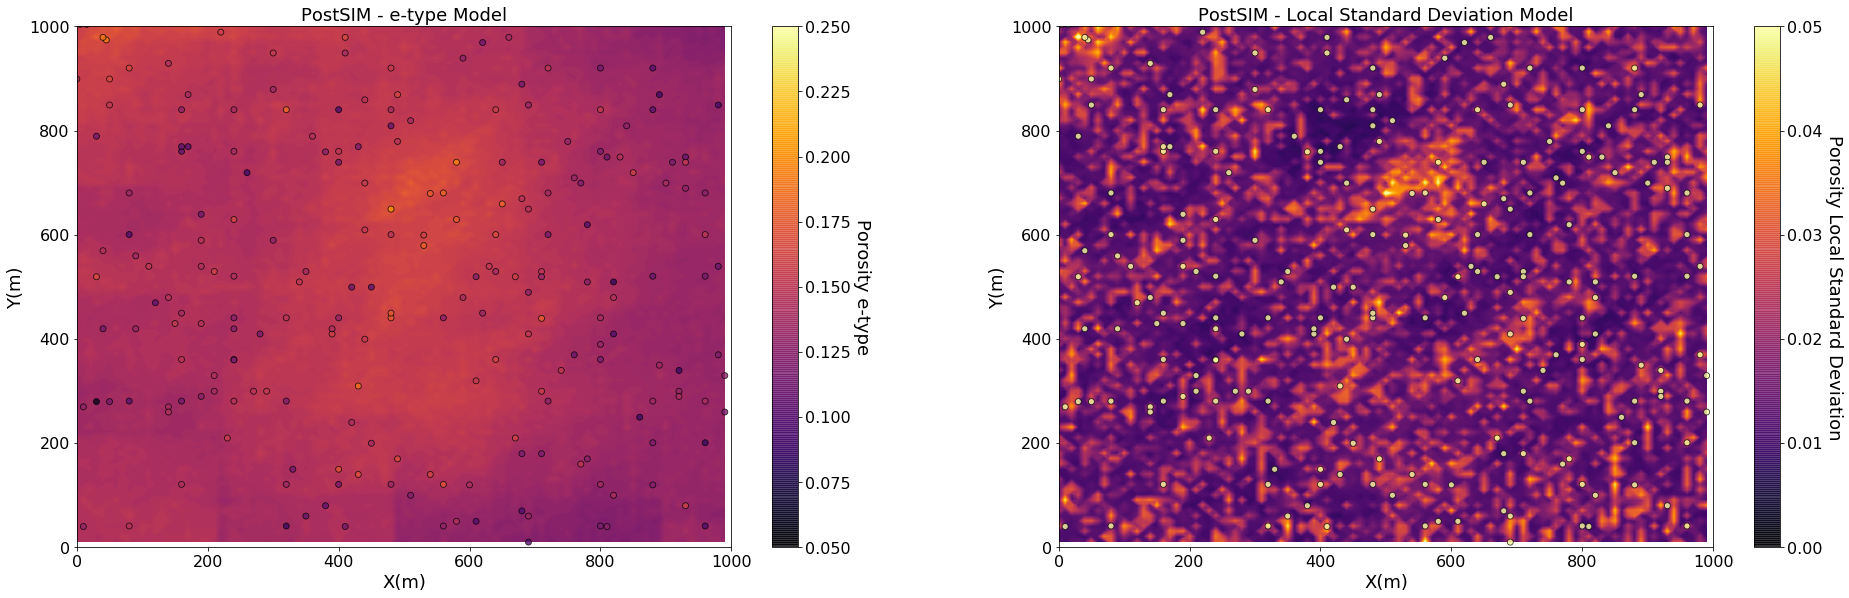

In [111]:
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno

e_type = local_expectation(cookie_por)
local_stdev = local_standard_deviation(cookie_por)

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','PostSIM - e-type Model','X(m)','Y(m)','Porosity e-type',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(local_stdev,xmin,xmax,ymin,ymax,xsiz,0.0,0.05,df,'X','Y','Porosity','PostSIM - Local Standard Deviation Model','X(m)','Y(m)','Porosity Local Standard Deviation',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=2.65, wspace=0.2, hspace=0.2)
plt.show()

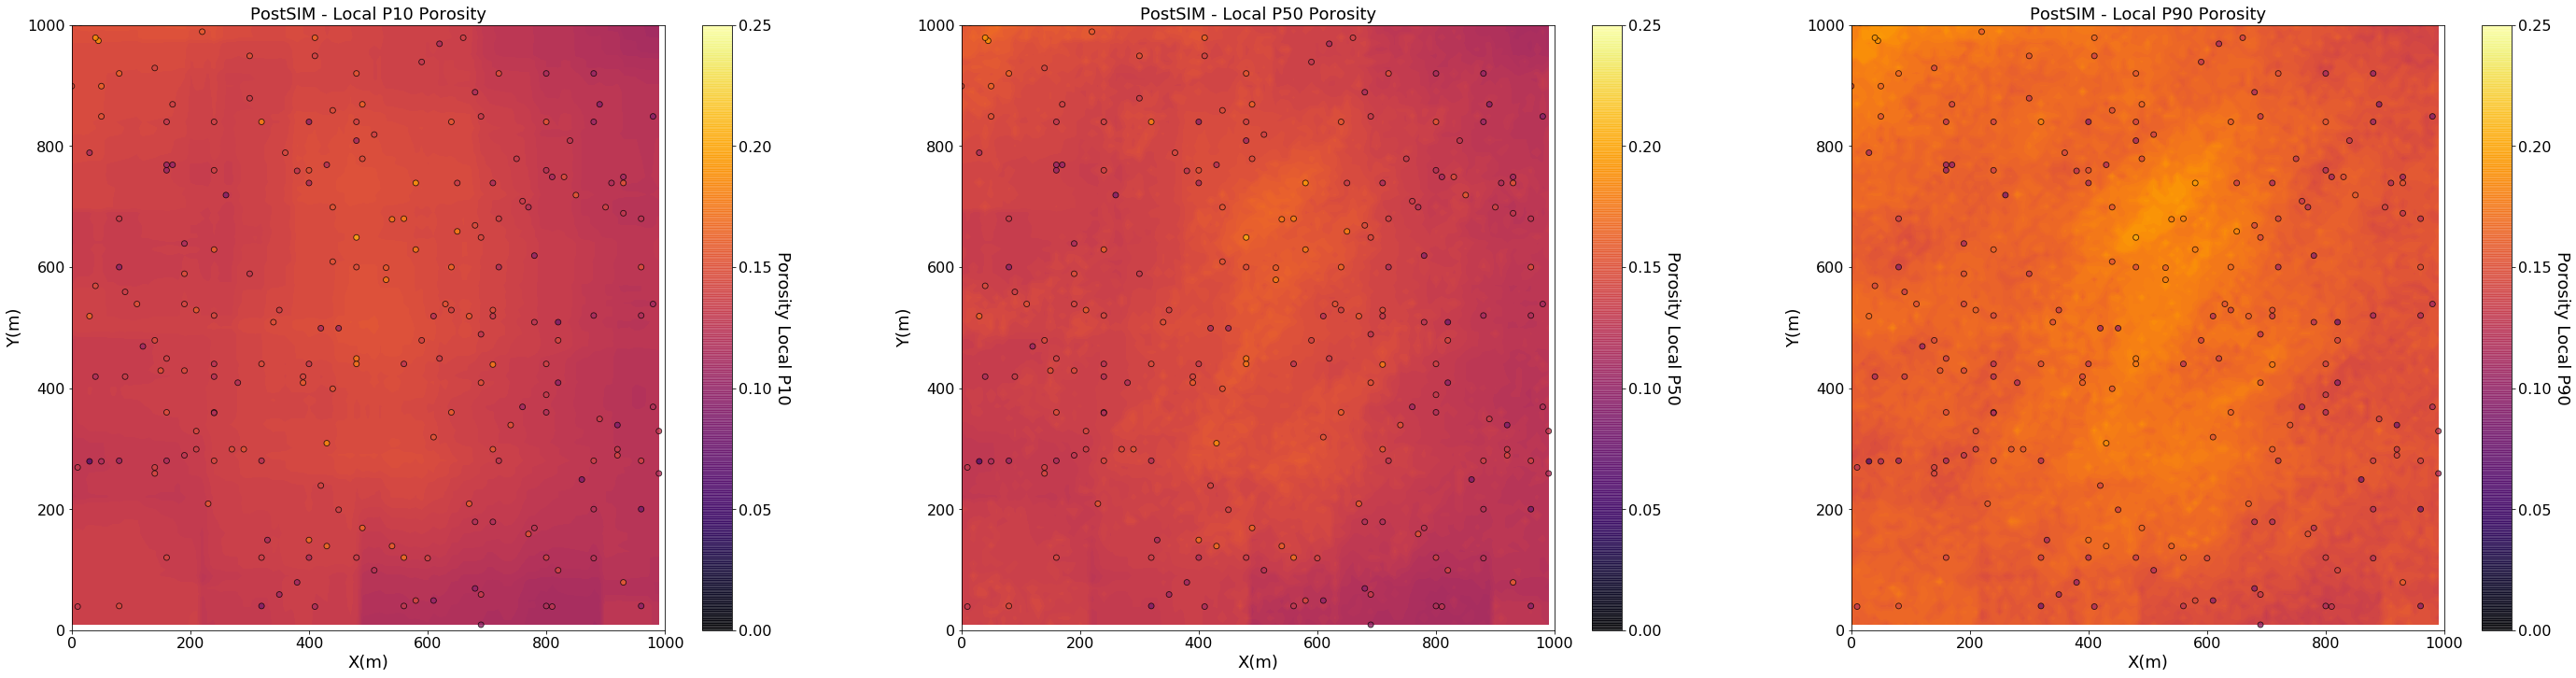

In [112]:
# local percentiles
localp10 = local_percentile(realizations = cookie_por,p_value = 10)

localp50 = local_percentile(realizations = cookie_por,p_value = 50)

localp90 = local_percentile(realizations = cookie_por,p_value = 90)


plt.subplot(1,3,1)
GSLIB.locpix_st(localp10,xmin,xmax,ymin,ymax,xsiz,0.0,.25,df,'X','Y','Porosity','PostSIM - Local P10 Porosity','X(m)','Y(m)','Porosity Local P10',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(localp50,xmin,xmax,ymin,ymax,xsiz,0.0,.25,df,'X','Y','Porosity','PostSIM - Local P50 Porosity','X(m)','Y(m)','Porosity Local P50',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(localp90,xmin,xmax,ymin,ymax,xsiz,0.0,.25,df,'X','Y','Porosity','PostSIM - Local P90 Porosity','X(m)','Y(m)','Porosity Local P90',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.75, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

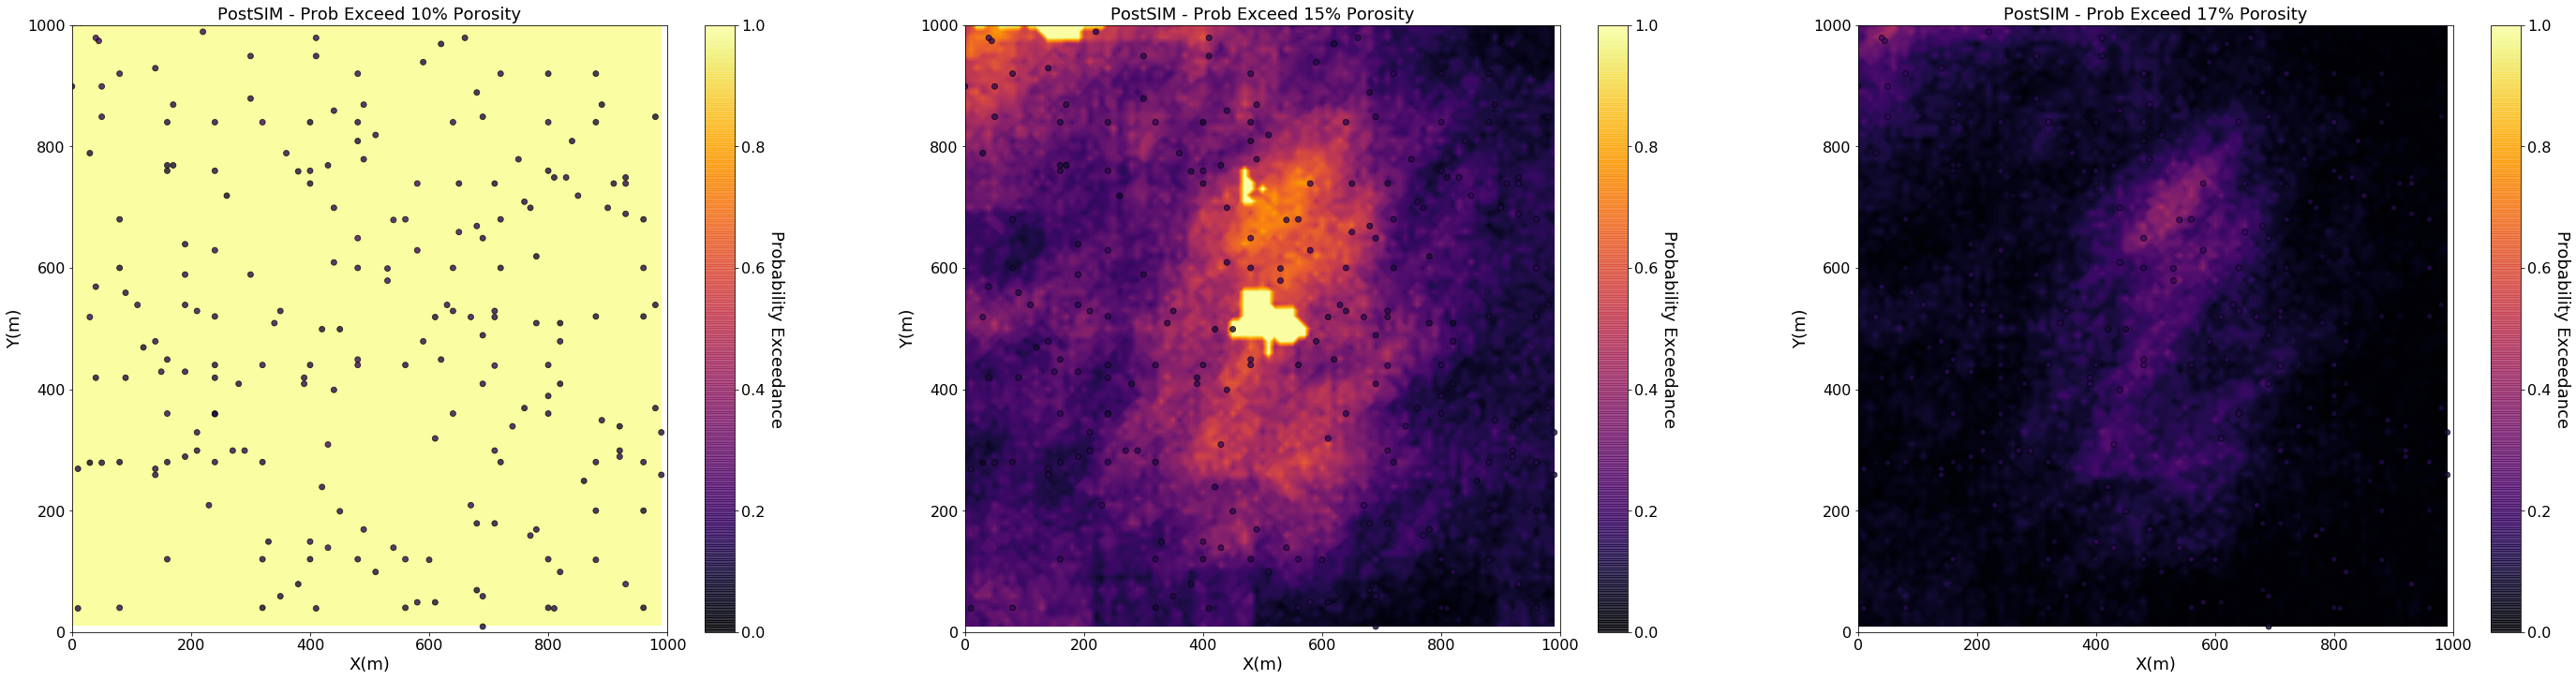

In [113]:
# local exceedance prob.
prob10 = local_probability_exceedance(realizations = cookie_por,threshold = 0.10)

prob13 = local_probability_exceedance(realizations = cookie_por,threshold = 0.15)

prob16 = local_probability_exceedance(realizations = cookie_por,threshold = 0.17)

plt.subplot(1,3,1)
GSLIB.locpix_st(prob10,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 10% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(prob13,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 15% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(prob16,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,'X','Y','Porosity','PostSIM - Prob Exceed 17% Porosity','X(m)','Y(m)','Probability Exceedance',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.75, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

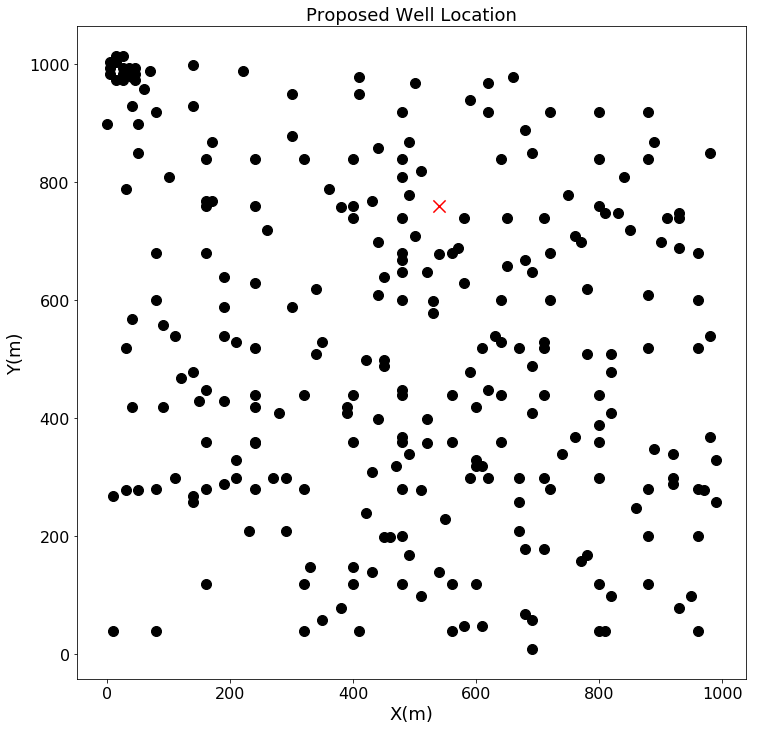

In [227]:
# Proposed well location
cookie_por = np.load('uncertaintyporosity100.npy')
prob16 = local_probability_exceedance(realizations = cookie_por,threshold = 0.16)
x = 540; y = 760
plt.figure()
df = pd.read_csv('1_sample_data.csv')

plt.scatter(df['X'],df['Y'],s=100,c='black',
           marker=None,cmap=plt.cm.plasma,norm=None,vmin=0.00,
           vmax=1.00,alpha=1.0,verts=None,edgecolors="black",label='Outliers')
fig = plt.gcf()
plt.scatter(x,y,s=150,c='red',marker='x')
plt.title('Proposed Well Location')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.rcParams["figure.figsize"] = (12,12)
plt.show()


#GSLIB.locpix_st(prob16,xmin,xmax,ymin,ymax,xsiz,0.0,1.,df,
#                'X','Y','Porosity','Probability of Exceeding 16% Porosity',
#                'X(m)','Y(m)','Probability  of Exceedance',cmap)

#Exceedance = plt.imshow(prob16, cmap=plt.cm.inferno, extent=(0, 1000, 0, 1000))
#plt.clim(0, 1)
#plt.xlabel('X (Meters)')
#plt.ylabel('Y (Meters)')
#plt.title('Probability of Exceeding 16% Porosity')
#plt.colorbar()
#plt.rcParams.update({'font.size': 14})
#fig1 = plt.gcf()
#plt.show(Exceedance)
#plt.rcParams["figure.figsize"] = (12,12)

#plt.scatter(x,y,s=150,c='white',marker='x')

#plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1.5, wspace=0.2, hspace=0.2)
#plt.show()
#plt.rcParams["figure.figsize"] = (5,5)
#fig.savefig('ProposedWell.png',dpi=100)

## Estimation of Oil in Place At Proposed Well Location

Porosity at Proposed Well Location
Mean: 0.1610997690998065
STD: 0.01960625550780036


/home/preston/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


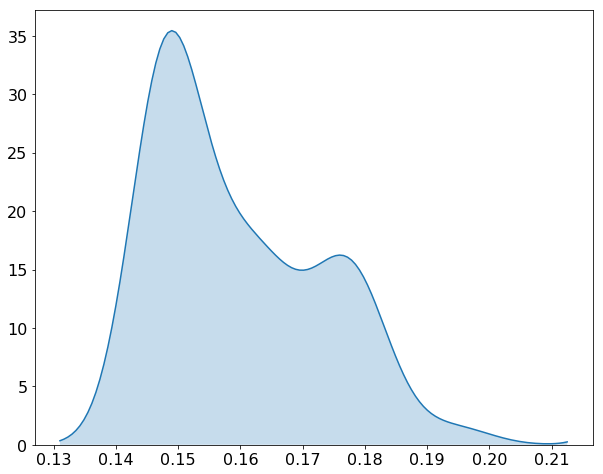

In [239]:
import seaborn as sns
Porosity_uncertainty = np.load('uncertaintyporosity100.npy') # Simulation results for porosity (cookie-cutter)
x = 540; y = 760
Saturation = 0.9 # Oil saturation
Conversion_factor = 6.29 # Conversion factor between m^3 and barrels
Thickness = 20.0 # Reservoir Thickness

PorAtCandidateWell = Porosity_uncertainty[:,24,54]
sns.kdeplot(PorAtCandidateWell[Porosity_uncertainty[:,24,54]<0.25],shade=True)
print('Porosity at Proposed Well Location')
print('Mean: ' +str(np.mean(Porosity_uncertainty[:,24,54])))
print('STD: ' +str(np.std(Porosity_uncertainty[:,24,54])))

### Uncertainty in OIP Global

In [132]:
Mean = np.empty((100,100))
STD = np.empty((100,100))

for i in range(100):
    for j in range(100):
        Mean[i,j] = np.mean(Porosity_uncertainty[:,i,j])
        STD[i,j] = np.std(Porosity_uncertainty[:,i,j])
MeanOIP = Mean*0.9*6.29*20.0
STDOIP = STD*0.9*6.29*20.0

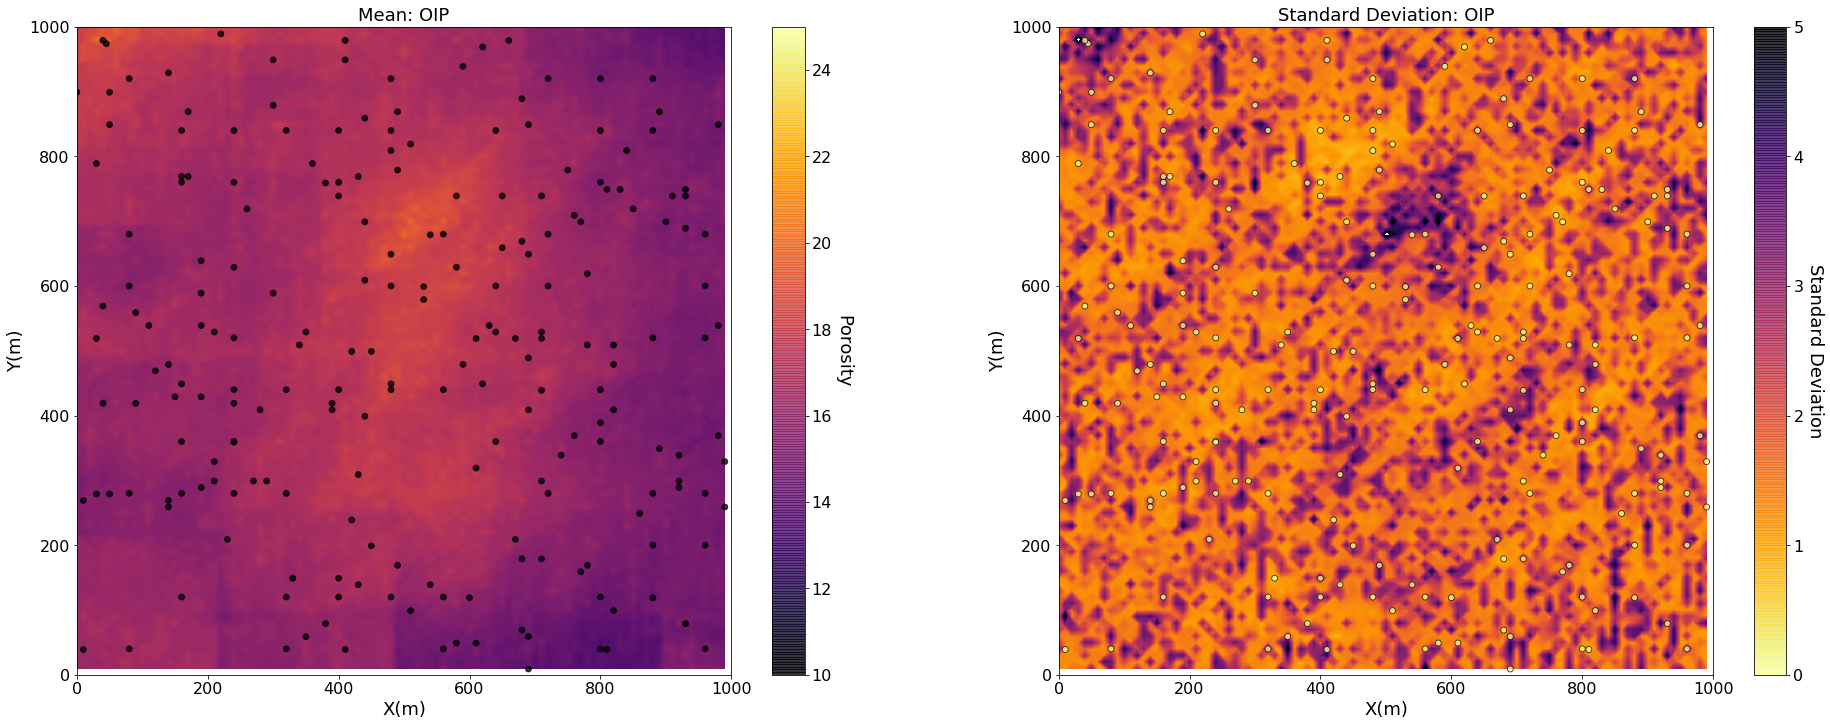

In [135]:
plt.figure()
plt.subplot(121)
GSLIB.locpix_st(MeanOIP,xmin,xmax,ymin,ymax,xsiz,10.0,25.0,df,
                'X','Y','Porosity','Mean: OIP',
                'X(m)','Y(m)','Porosity',plt.cm.inferno)

plt.subplot(122)
GSLIB.locpix_st(STDOIP,xmin,xmax,ymin,ymax,xsiz,0.0,5.0,df,
                'X','Y','Porosity','Standard Deviation: OIP',
                'X(m)','Y(m)','Standard Deviation',plt.cm.inferno_r)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

Global OIP Distribution [1e6 Barrels]
Mean: 16.323876749236945
Standard Deviation: 1.0385270005149727


/home/preston/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


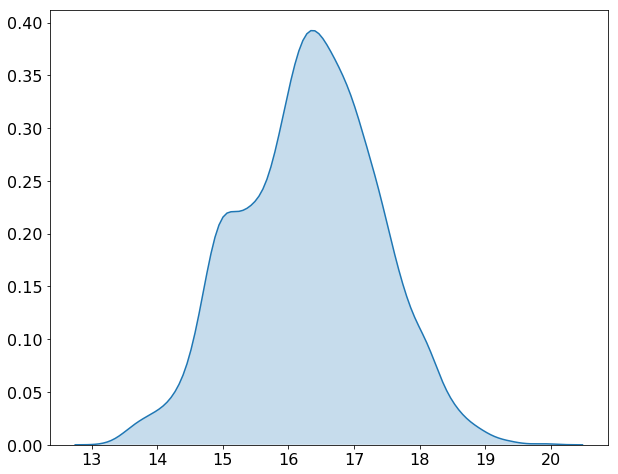

In [241]:
print('Global OIP Distribution [1e6 Barrels]')
print('Mean: ' + str(np.mean(MeanOIP.ravel())))
print('Standard Deviation: ' + str(np.std(MeanOIP.ravel())))
sns.kdeplot(MeanOIP.ravel(),shade=True)

In [242]:
P10 = np.percentile(MeanOIP.ravel(),10)
P50 = np.percentile(MeanOIP.ravel(),50)
P90 = np.percentile(MeanOIP.ravel(),90)
print('P10: '+str(P10))
print('P50: '+str(P50))
print('P90: '+str(P90))

P10: 14.930131610389282
P50: 16.360149261347072
P90: 17.64507128504203
